<a href="https://colab.research.google.com/github/conorlime/CS6271/blob/main/GE%20Applied%20to%20Classification%20(Single%20Type).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#**Artificial Intelligence - MSc**
##CS6271 - Evolutionary Agorithms and Humanoid Robotics
###GE Applied to single type classification


Leader: Conor Ryan

Developer: Allan de Lima

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone this repository in which we have all functions and classes created or adapted to this work.

In [2]:
import os.path

PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

grape directory already exists
/content/drive/MyDrive/grape


Import our algorithms, adapted from deap.algorithms.


Import functions used by our grammars.



In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install deap

import grape
import algorithms

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools

import random

from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.8 MB/s eta 0:00:00


Set our Grammatical Evolution parameters.

In [5]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be smaller or equal to HALLOFFAME_SIZE
HALLOFFAME_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be at least 1

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 5
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']


Set a random seed.

In [6]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Set a problem to solve. This notebook is ready to run experiments for 'spambase' and 'Banknote'. And you could easily modify for other problems.

In [7]:
problem = 'Banknote'

Read datasets and grammars according to the problem picked in the previous cell.

In [8]:
if problem == 'Banknote':
    from functions import add, sub, mul, pdiv, neg, psqrt, plog
    X_train = np.zeros([1000, 4], dtype=float)
    Y_train = np.zeros([1000,], dtype=bool)
    X_test = np.zeros([372, 4], dtype=float)
    Y_test = np.zeros([372,], dtype=bool)

    data = pd.read_table(r"datasets/banknote_Train.csv", sep=" ")
    for i in range(1000):
        for j in range(4):
            X_train[i,j] = data['x'+ str(j)].iloc[i]
    for i in range(1000):
        Y_train[i] = data['y'].iloc[i] > 0

    data = pd.read_table(r"datasets/banknote_Test.csv", sep=" ")
    for i in range(372):
        for j in range(4):
            X_test[i,j] = data['x'+ str(j)].iloc[i]
    for i in range(372):
        Y_test[i] = data['y'].iloc[i] > 0

    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)

    GRAMMAR_FILE = 'Banknote.bnf'

elif problem == 'spambase':
    from functions import add, sub, mul, pdiv, neg
    X = np.zeros([4601, 57], dtype=float)
    Y = np.zeros([4601,], dtype=int)

    data = pd.read_table(r"datasets/spambase.csv")
    for i in range(4601):
        for j in range(57):
            X[i,j] = data['d'+ str(j)].iloc[i]
    for i in range(4601):
        Y[i] = data['class'].iloc[i]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED)

    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)

    GRAMMAR_FILE = 'spambase.bnf'

Print data.

In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

data.head()

,x0,x1,x2,x3,y
0,-2.2183,-1.2540,2.99860,0.36378,1.0
1,-1.8046,-6.8141,6.70190,1.16810,1.0
2,-4.5770,3.4515,0.66719,-0.94742,1.0
3,2.7161,-4.2006,4.19140,0.16981,-1.0
4,3.8905,-2.1521,2.63020,1.10470,-1.0


Print grammar.

In [10]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close()

<e> ::= (<e> <op> <e>) | <f1>(<e>) | <f2>(<e>, <e>) | <v> | <c>
<op> ::= + | * | -
<f1> ::= psqrt | plog
<f2> ::= pdiv
<v> ::= x[0] | x[1] | x[2] | x[3]
<c> ::= -1.0 | -0.1 | -0.01 | -0.001 | 0.001 | 0.01 | 0.1 | 1.0


Set up the grammar addressed by GRAMMAR_FILE in the class Grammar.

In [11]:
BNF_GRAMMAR = grape.Grammar(path.join("grammars", GRAMMAR_FILE))

Define as fitness function the number of outputs wrongly predicted.

In [12]:
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FloatingPointError and OverflowError can happen for example, if you have lots of pow/exp calls
        # ZeroDivisionError can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    try:
        Y_class = [1 if pred[i] > 0 else 0 for i in range(len(Y))]
    except (IndexError, TypeError):
        return np.NaN,

    compare = np.equal(Y,Y_class)
    fitness = 1 - np.mean(compare)

    return fitness,

Create the deap toolbox.

Use negative weights in the `base.Fitness` since we are trying to minimise the fitness.

`grape.Individual` is a class with the following attributes: `phenotype`, `nodes`, `depth`, `used_codons`, `invalid` (True or False), `n_wraps` and `self.structure`.

`grape.sensible_initialisation` initialises a whole population of GE individuals using Sensible Initialisation.

`tools.selTournament` usef Tournament to select parents.

`grape.crossover_onepoint` selects crossover points within the used portion of the genome.

Similarly, `grape.mutation_int_flip_per_codon` performs only over the effective length.



In [13]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
#toolbox.register("populationCreator", grape.random_initialisation, creator.Individual)

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", tools.selTournament, tournsize=7)

# Single-point crossover:
toolbox.register("mate", grape.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", grape.mutation_int_flip_per_codon)


Set the main function and run it.

Set the statistics object regarding the fitness score, but there are other statistics defined internally.

Perform Grammatical Evolution using `algorithms.ge_eaSimpleWithElitism`, a simple evolutionary algorithm. The differences to the `algorithms.ge_eaSimpleWithElitism` used by deap are:

*   We use elitism (if you do not want to use, just set ELITISM_SIZE = 0);
*   After crossover and mutation, we check the offspring to assure that the max depth is not violated;
*   We measure many other things to report, such as the generation and the selection times, the number of invalid individuals etc.

In [14]:
# create initial population (generation 0):
population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              points_test=[X_test, Y_test],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (0.15100000000000002,)
gen = 1 , Best fitness = (0.14700000000000002,) , Number of invalids = 233
gen = 2 , Best fitness = (0.14400000000000002,) , Number of invalids = 183
gen = 3 , Best fitness = (0.139,) , Number of invalids = 143
gen = 4 , Best fitness = (0.137,) , Number of invalids = 94
gen = 5 , Best fitness = (0.131,) , Number of invalids = 81
gen = 6 , Best fitness = (0.128,) , Number of invalids = 61
gen = 7 , Best fitness = (0.128,) , Number of invalids = 56
gen = 8 , Best fitness = (0.121,) , Number of invalids = 60
gen = 9 , Best fitness = (0.121,) , Number of invalids = 51
gen = 10 , Best fitness = (0.10899999999999999,) , Number of invalids = 55
gen = 11 , Best fitness = (0.10899999999999999,) , Number of invalids = 50
gen = 12 , Best fitness = (0.05700000000000005,) , Number of invalids = 36
gen = 13 , Best fitness = (0.05700000000000005,) , Number of invalids = 44
gen = 14 , Best fitness = (0.05700000000000005,) , Number of invalids = 46
gen = 

Show the best individual.

In [15]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 pdiv(-1.0, (((x[0] + x[1]) + x[2]) + ((x[0] + pdiv(plog(x[2]), x[2])) -
(psqrt(plog((psqrt((psqrt(x[1]) - (x[0] + pdiv(plog(x[2]), x[2])))) -
(psqrt(plog((psqrt(x[1]) - ((1.0 + x[2]) + psqrt(psqrt(x[2])))))) + psqrt((x[0]
+ (x[0] + (psqrt(x[0]) + (-1.0 * 0.1))))))))) * psqrt(((((0.1 - x[0]) + x[2]) -
(psqrt(x[1]) - (x[0] - pdiv(plog(x[2]), x[2])))) - (psqrt(plog((psqrt(x[2]) *
psqrt(x[2])))) + psqrt((x[0] + (x[0] + (psqrt(x[0]) - (-1.0 * 0.1))))))))))))

Training Fitness:  0.0010000000000000009
Depth:  17
Length of the genome:  471
Used portion of the genome: 0.37


Extract statistics and build a nice table.

In [16]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values, fitness_test,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,0.554508,0.106130,0.151,0.850,NaN,13,148.257344,5,54.823737,8.050529,98.970623,9,0.000000,0.803319
1,1,233,0.491668,0.127609,0.147,0.850,NaN,40,209.014608,16,49.907039,9.104914,90.104914,27,0.007962,2.638720
2,2,183,0.441979,0.163215,0.144,0.851,NaN,119,207.006258,46,42.610763,9.663329,76.963705,80,0.016416,5.147083
3,3,143,0.375106,0.202042,0.139,0.853,NaN,119,177.197590,46,28.526506,8.965060,51.342169,80,0.015424,2.414774
4,4,94,0.299881,0.212365,0.137,0.869,NaN,241,160.137097,6,19.231567,8.479263,34.353687,11,0.039876,2.862153
5,5,81,0.313182,0.216279,0.131,0.863,NaN,47,162.834081,23,18.632287,8.565022,33.386771,44,0.022678,2.203408
6,6,61,0.318858,0.217572,0.128,0.853,NaN,53,169.661910,8,20.507135,8.976948,36.811196,14,0.015769,2.425608
7,7,56,0.316404,0.219225,0.128,0.883,NaN,53,174.907909,8,19.882990,9.047671,35.682557,14,0.014084,2.945188
8,8,60,0.313509,0.213561,0.121,0.863,NaN,215,183.766376,25,21.979258,9.548035,39.733624,45,0.015226,1.744646
9,9,51,0.299232,0.205364,0.121,0.863,NaN,215,178.962766,25,21.035106,9.503191,38.252128,45,0.014529,1.096274


Plot graph regarding the best individual in each generations considering the training set.

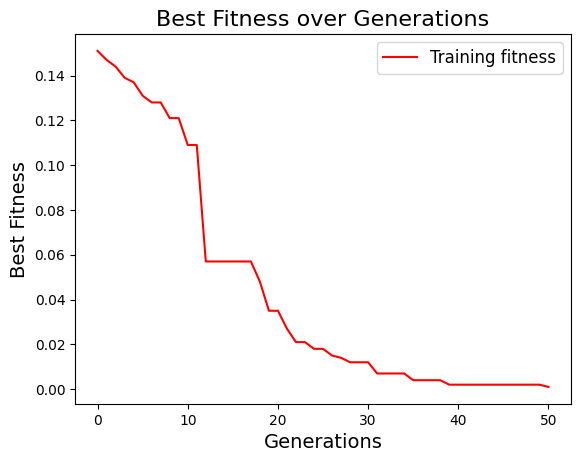

In [17]:
plt.plot(gen, min_fitness_values, color='red', label="Training fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.show()


Show the score in the test set.

In [18]:
print("\nTest Fitness: ", fitness_test[-1])


Test Fitness:  0.005376344086021501


Plot graph regarding the average fitness in each generation considering the training set.

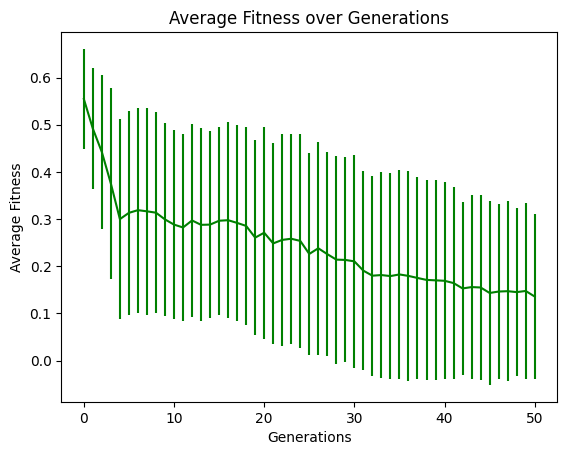

In [19]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

Plot graphs regarding the length of the genome: the average of the population and that one of the best individual.


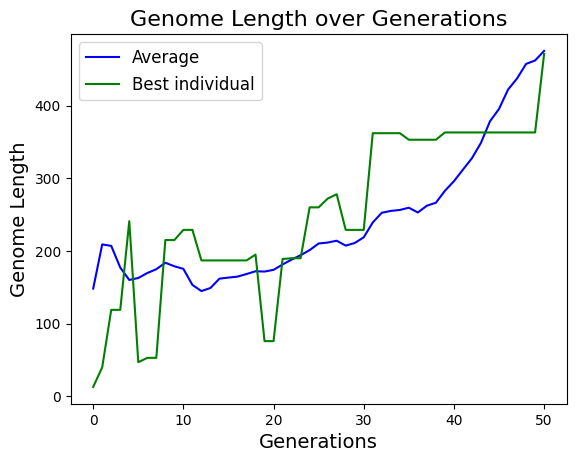

In [20]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()